# Convolutional Neural Networks Tuning

In our [previous attempt](./02-cnn-tuned.ipynb) at image classification, we built a pretty decent convolutional neural network and achieved a respectable 75% accuracy on the CIFAR-10 dataset. However, we also observed a clear sign of overfitting - while training accuracy climbed, validation accuracy began to plateau and even dip.

In this notebook, we will try to mitigate this issue by using multiple tuning techniques, that will improve the model accuracy and make it much more robust. 

## Data Preparation

We will start by loading and preparing the CIFAR-10 dataset, just as we did before. This involves loading the data, defining human-readable class names, and normalizing the pixel values.

In [1]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [2]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

## Data Augmentation

Then, we may apply a technique called **data augumentation**. That's one of the most effective ways to combat overfitting and improve model generalization, especially with image data. 

This technique involves applying random (but realistic) transformations to our existing training images, effectively creating new training samples on the fly. This helps the model learn to be invariant to these slight variations - instead of simply memoizing them.

In [3]:
from tensorflow.keras import layers, Sequential

data_augmentation = Sequential([
    layers.RandomCrop(32, 32),
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.15),
])

Let's visualize what these augmentations look like on a few sample images from our training set. You may clearly see that each image is slightly different from its original, yet still clearly recognizable. Note that we clip values to `[0, 1]` for proper display after augmentation, as some transformations might push pixel values slightly out of this range.

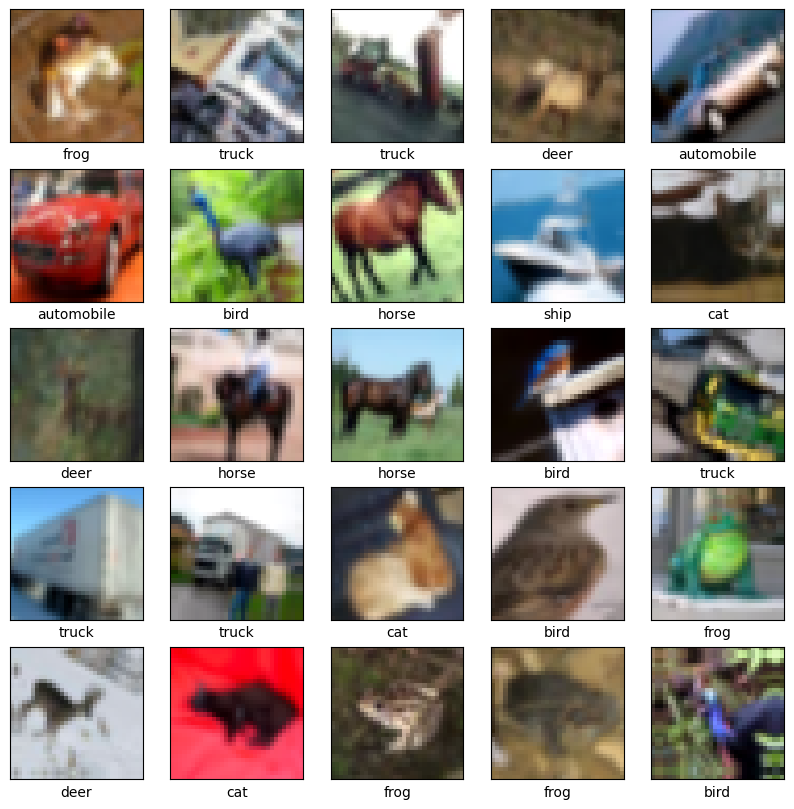

In [4]:
import matplotlib.pyplot as plt
import numpy as np

augmented_example = data_augmentation(x_train[:25])
plt.figure(figsize=[10, 10])

for i in range(len(augmented_example)):
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.clip(augmented_example[i], 0, 1), cmap=plt.cm.binary)
  plt.xlabel(class_names[y_train[i][0]])

plt.show()

## Label Encoding

In [5]:
from tensorflow.keras.utils import to_categorical
y_train_encoded = to_categorical(y_train, num_classes=len(class_names))
y_test_encoded = to_categorical(y_test, num_classes=len(class_names))

## Building and Training the Model

For our improved model, we'll adopt a more robust, [VGG-inspired architecture](https://en.wikipedia.org/wiki/VGGNet), incorporating multiple normalization layers to stabilize training and deeper convolutional blocks to learn more intricate features.

Its core idea is to use repeating blocks of convolutional layers. Each block will consist of:

-   **Convolutional Layers:** We use two convolutional layers back-to-back. The first one finds initial features (like edges), and the second one looks at those features to find slightly more complex patterns (like corners or textures made of those edges) before we simplify things. It's like taking a first look, then a closer second look.
-   **Batch Normalization:** After our convolutional layers work their magic, it steps in. It helps keep the learning process smooth and steady, like a good guide keeping everyone on track. This helps the network train faster and can also prevent it from getting too stuck on the training data (overfitting).
-   **Activation Function:** Just like before, the `ReLU` activation helps the network make non-linear decisions, deciding which features are important enough to pass on. Note that is is put after the batch normalization, which is a pretty common practice.
-   **Feature Condenser:** After finding detailed features, it picks out the strongest signals and shrinks the information. This makes our model more efficient and helps it recognize objects even if they are slightly moved or rotated.
-   **Dropout:** To stop our network from simply memorizing the training images (which would make it bad at recognizing new images), it randomly ignores some of the learned features during training. This forces the network to be more robust and general ways to identify objects.

By stacking these blocks, and progressively increasing the number of filters, we could build a neural network able to to perform complex visual understanding. The initial blocks might learn simple edges and colors, while deeper blocks combine these to recognize textures, parts of objects, and eventually, the objects themselves.

In [6]:
from tensorflow.keras import layers
def vgg_block(filters, dropout_rate=0.15):
    return layers.Pipeline([
        layers.Conv2D(filters, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(filters, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),
    ])

Just as before, our full model will consist of the **feature learning** part, now built by stacking several of these VGG blocks, and the integrated data augmentation layer. This is then followed by the **classification** part, which takes these learned features and decides what object is in the image.

In [7]:
from tensorflow.keras import Sequential

num_classes = len(class_names)
input_shape = x_train.shape[1:]

feature_learning = Sequential([
    layers.Input(shape=input_shape),
    data_augmentation,
    vgg_block(32),
    vgg_block(64),
    vgg_block(128),
    vgg_block(256),
])

classification = Sequential([
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.35),
    layers.Dense(num_classes, activation='softmax'),
])

model = Sequential([
    feature_learning,
    classification,
])

To aid our training process and combat overfitting more effectively, we will use a couple of callbacks:

- **Reduce Learning Rate**: This will reduce the learning rate when the validation loss stops improving, helping the model to fine-tune.
- **Early Stopping**: This will stop training if the validation loss doesn't improve for a set number of epochs, also restoring the weights from the best epoch. We'll give it a bit more patience this time.

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=8, min_lr=0.00001)
callbacks = [reduce_lr, earlystop]

We'll might also use the `AdamW` optimizer, which is an extension of the Adam optimizer that incorporates the normalization technique called **weight decay**, often leading to better generalization.

That's a regularization technique that helps prevent overfitting by adding a penalty to the loss function proportional to the model's weights. By keeping them smaller, the model tends to be simpler and less likely to fit the noise in the training data, leading to better generalization on unseen data.

In [9]:
from tensorflow.keras.optimizers import AdamW
optimizer = AdamW(weight_decay=0.001)

Now, let's compile and train our tuned model. This time we might start using the GPU - our model is finally complex enough to leverage the parallelism it offers to speed up the training process.

In [10]:
from tensorflow import device
with device('/GPU'):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train_encoded, epochs=120, batch_size=64, callbacks=callbacks, validation_split=0.2)

Epoch 1/120
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 65ms/step - accuracy: 0.3173 - loss: 2.0250 - val_accuracy: 0.5261 - val_loss: 1.3037 - learning_rate: 0.0010
Epoch 2/120
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.5015 - loss: 1.3959 - val_accuracy: 0.6225 - val_loss: 1.0665 - learning_rate: 0.0010
Epoch 3/120
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.5868 - loss: 1.1730 - val_accuracy: 0.5550 - val_loss: 1.2927 - learning_rate: 0.0010
Epoch 4/120
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.6337 - loss: 1.0515 - val_accuracy: 0.6321 - val_loss: 1.1115 - learning_rate: 0.0010
Epoch 5/120
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.6613 - loss: 0.9739 - val_accuracy: 0.6468 - val_loss: 1.0793 - learning_rate: 0.0010
Epoch 6/120
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - accuracy: 0.6865 - loss: 0.9024 - val_accuracy: 0.6738 - val_loss: 0.9711 - learning_rate: 0.0010
Epoch 7/120
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.7

## Result

In [11]:
from sklearn.metrics import classification_report
import numpy as np
with device('/GPU'):
    y_pred_probs = model.predict(x_test, verbose=False)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    y_true_labels = np.argmax(y_test_encoded, axis=1)
    print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.90      0.90      0.90      1000
  automobile       0.92      0.96      0.94      1000
        bird       0.83      0.85      0.84      1000
         cat       0.81      0.72      0.76      1000
        deer       0.86      0.86      0.86      1000
         dog       0.86      0.78      0.82      1000
        frog       0.84      0.95      0.89      1000
       horse       0.91      0.91      0.91      1000
        ship       0.94      0.92      0.93      1000
       truck       0.88      0.93      0.90      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Conclusion

By systematically incorporating data augmentation, architectural changes, and intelligent training callbacks like learning rate reduction and early stopping, we've substantially boosted our model's performance. The leap from 75% to a much more compelling **88%** accuracy on the CIFAR-10 test set clearly demonstrates the power of these combined techniques.

More importantly, these improvements weren't just about chasing a higher accuracy figure - they were crucial in addressing the overfitting observed previously. The model now generalizes better to unseen data, making it more much more reliable. 

While this tuned model shows significant progress, future improvements could involve experimenting with even deeper or wider networks, attention mechanisms, or leveraging transfer learning for even greater accuracy.